## Movie Recommendation Systems
Project Proposal : I plan to use The Movies dataset from kaggle to create a recommendation engine for users

Dataset: Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages. This dataset also has files containing 100,000 ratings from 700 users for a small subset of 9,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.

## Loading the data

In [2]:
%matplotlib inline
import datetime
import ast
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import surprise as sp
import warnings
warnings.filterwarnings('ignore')
    
from scipy import stats
from ast import literal_eval
from surprise import Reader, Dataset, SVD, BaselineOnly
from surprise.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

# To create interactive plots
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To create deep learning models
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model

# To create sparse matrices
from scipy.sparse import coo_matrix

# To light fm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

# To stack sparse matrices
from scipy.sparse import vstack

Using TensorFlow backend.


In [3]:
df = pd.read_csv('D:/Cinci prep/Coursework/Python/the-movies-dataset/movies_metadata.csv')
ratings = pd.read_csv('D:/Cinci prep/Coursework/Python/the-movies-dataset/ratings_small.csv')
links_small = pd.read_csv('D:/Cinci prep/Coursework/Python/the-movies-dataset/links_small.csv')
credits = pd.read_csv('D:/Cinci prep/Coursework/Python/the-movies-dataset/credits.csv')
keywords = pd.read_csv('D:/Cinci prep/Coursework/Python/the-movies-dataset/keywords.csv')

In [4]:
print("The movies dataset has {} rows and {}columns".format(df.shape[0],df.shape[1]))

The movies dataset has 45466 rows and 24columns


In [5]:
#add object type to table

| Column Name | Description |
| :- | :- |
| adult | Indicates if the movie is X-Rated or Adult. |
| belongs_to_collection | Information on the movie series the particular film belongs to |
| budget | The budget of the movie in dollars. |
|genres: | genres associated with the movie |
| homepage | The Official Homepage of the move |
|id |: The ID of the move. |
| imdb_id |  The IMDB ID of the movie. |
| original_language |  The language in which the movie was originally shot in. |
| original_title |  The original title of the movie. |
| overview |  A brief blurb of the movie. |
| popularity |  The Popularity Score assigned by TMDB. |
| poster_path |  The URL of the poster image. |
| production_companies |  List of Production companies involved in making of the movie |
| production_countries |  List of countries where the movie was shot/produced in. |
| release_date |  Theatrical Release Date of the movie. |
| revenue |  The total revenue of the movie in dollars. |
| runtime |  The runtime of the movie in minutes. |
| spoken_languages |  A stringified list of spoken languages in the film. |
| status |  The status of the movie (Released, To Be Released, Announced, etc.) |
| tagline |  The tagline of the movie. |
| title | The Official Title of the movie. |
| video | Indicates if there is a video present of the movie with TMDB. |
| vote_average | The average rating of the movie. |
| vote_count | The number of votes by users, as counted by TMDB. |

# DATA WRANGLING

## Meta_movies dataset

In [6]:
def missing_values(df):
    total_na = df.isnull().sum()
    percent = round((df.isnull().sum()/df.isnull().count()*100),2)
    output =  pd.concat([total_na, percent], axis=1, keys=['Total', 'Percent (%)'])
    return output[output['Percent (%)']>0].sort_values(by = ['Percent (%)'],ascending = False)

missing_values(df)

,Total,Percent (%)
belongs_to_collection,40972,90.12
homepage,37684,82.88
tagline,25054,55.10
overview,954,2.10
poster_path,386,0.85
runtime,263,0.58
status,87,0.19
release_date,87,0.19
imdb_id,17,0.04
original_language,11,0.02


In [7]:
df['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 - Written by Ørnås                                                                                                                   1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

In [8]:
df[(df['title'].isna())==True]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19729,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,82663,tt0113002,en,Midnight Man,British soldiers force a recently captured IRA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29502,False,"{'id': 122661, 'name': 'Mardock Scramble Colle...",0,"[{'id': 16, 'name': 'Animation'}, {'id': 878, ...",http://m-scramble.jp/exhaust/,122662,tt2423504,ja,マルドゥック・スクランブル 排気,Third film of the Mardock Scramble series.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35586,False,NaN,0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 28,...",NaN,249260,tt2622826,en,Avalanche Sharks,A group of skiers are terrorized during spring...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df = df[df['title'].notna()]

In [10]:
df[df['original_title'] != df['title']][['title', 'original_title']].shape

(11396, 2)

In [11]:
df = df.drop('imdb_id', axis=1)
df = df.drop('original_title', axis=1)
df = df.drop('adult', axis=1)

In [12]:
base_poster_url = 'http://image.tmdb.org/t/p/w185/'
df['poster_path'] = "<img src='" + base_poster_url + df['poster_path'] + "' style='height:100px;'>"

In [13]:
print("The meta_movies final dataset has {} rows and {}columns".format(df.shape[0],df.shape[1]))

The meta_movies final dataset has 45460 rows and 21columns


In [14]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [15]:
df['revenue'] = df['revenue'].replace(0, np.nan)
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)

In [16]:
df['Revenue (in Millions)'] = round(df['revenue'] / 1000000,2)
df['Budget (in Millions)'] = round(df['budget'] / 1000000,2)
df['Returns per $ spent'] = df['Revenue (in Millions)'] / df['Budget (in Millions)']

In [17]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [18]:
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')

## Credits dataset

In [19]:
credits_df = pd.read_csv('D:/Cinci prep/Coursework/Python/the-movies-dataset/credits.csv')
credits_df.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [20]:
print("The credits dataset has {} rows and {}columns".format(credits_df.shape[0],credits_df.shape[1]))

The credits dataset has 45476 rows and 3columns


In [21]:
missing_values(credits_df)

,Total,Percent (%)


# EDA

In [22]:
from IPython.display import Image, HTML

In [23]:
#highest grossing individual movies
gross_top = df[['poster_path', 'title','year', 'Budget (in Millions)', 'Revenue (in Millions)','Returns per $ spent']].sort_values('Revenue (in Millions)', ascending=False).head(5)
pd.set_option('display.max_colwidth', 500)
HTML(gross_top.to_html(escape=False))

,poster_path,title,year,Budget (in Millions),Revenue (in Millions),Returns per $ spent
14551,,Avatar,2009,237.0,2787.97,11.763586
26555,,Star Wars: The Force Awakens,2015,245.0,2068.22,8.441714
1639,,Titanic,1997,200.0,1845.03,9.225150
17818,,The Avengers,2012,220.0,1519.56,6.907091
25084,,Jurassic World,2015,150.0,1513.53,10.090200


In [24]:
#highest grossing franchises
df_fran = df[df['belongs_to_collection'].notnull()]
df_fran['belongs_to_collection'] = df_fran['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
df_fran = df_fran[df_fran['belongs_to_collection'].notnull()]

In [25]:
franchise_colln = df_fran.groupby('belongs_to_collection')['Revenue (in Millions)'].agg(No_of_movies='count', Avg_revenue_per_movie = 'mean',Gross_revenue='sum').sort_values('Gross_revenue', ascending=False).head(10)
franchise_colln

,No_of_movies,Avg_revenue_per_movie,Gross_revenue
belongs_to_collection,,,
Harry Potter Collection,8,963.421250,7707.37
Star Wars Collection,8,929.312500,7434.50
James Bond Collection,26,273.344615,7106.96
The Fast and the Furious Collection,8,640.636250,5125.09
Pirates of the Caribbean Collection,5,904.314000,4521.57
Transformers Collection,5,873.222000,4366.11
Despicable Me Collection,4,922.765000,3691.06
The Twilight Collection,5,668.422000,3342.11
Ice Age Collection,5,643.342000,3216.71


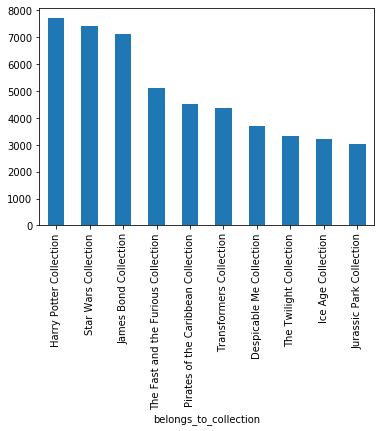

In [26]:
franchise_colln['Gross_revenue'].plot.bar();

In [27]:
#Biggest production companies
df['production_companies'] = df['production_companies'].fillna('[]').apply(ast.literal_eval)
df['production_companies'] = df['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [28]:
s = df.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'companies'
com_df = df.drop('production_companies', axis=1).join(s)

In [29]:
com_sum = pd.DataFrame(com_df.groupby('companies')['Revenue (in Millions)'].sum().sort_values(ascending=False))
com_sum.columns = ['Total_Revenue (in Millions)']
com_mean = pd.DataFrame(com_df.groupby('companies')['Revenue (in Millions)'].mean().sort_values(ascending=False))
com_mean.columns = ['Average_revenue_per_film (in Millions)']
com_count = pd.DataFrame(com_df.groupby('companies')['Revenue (in Millions)'].count().sort_values(ascending=False))
com_count.columns = ['Number of films produced']

com_pivot = pd.concat((com_sum, com_mean, com_count), axis=1)

In [30]:
com_pivot.sort_values('Total_Revenue (in Millions)', ascending=False).head(10)

,Total_Revenue (in Millions),Average_revenue_per_film (in Millions),Number of films produced
Warner Bros.,63525.28,129.379389,491
Universal Pictures,55259.15,119.350216,463
Paramount Pictures,48808.15,123.564937,395
Twentieth Century Fox Film Corporation,47687.58,139.846276,341
Walt Disney Pictures,40837.22,277.804218,147
Columbia Pictures,32279.79,136.778771,236
New Line Cinema,22173.44,111.987071,198
Amblin Entertainment,17343.73,255.054853,68
DreamWorks SKG,15475.72,198.406667,78
Dune Entertainment,15003.78,241.996452,62


In [31]:
#Movies per year per month
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [32]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [33]:
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [34]:
df['day'] = df['release_date'].apply(get_day)
df['month'] = df['release_date'].apply(get_month)

In [35]:
df_21 = df.copy()
df_21['year'] = df_21[df_21['year'] != 'NaT']['year'].astype(int)
df_21 = df_21[df_21['year'] >=2000]
hmap_21 = pd.pivot_table(data=df_21, index='month', columns='year', aggfunc='count', values='title')
hmap_21 = hmap_21.fillna(0)

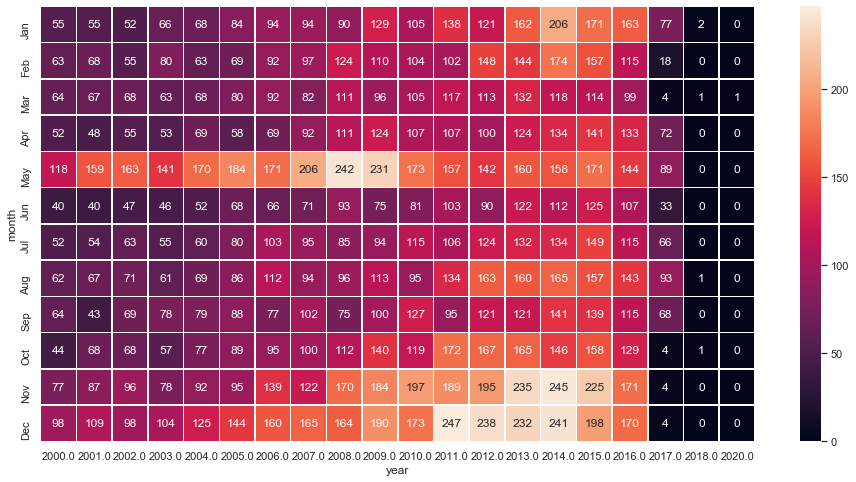

In [36]:
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(hmap_21, annot=True, linewidths=.5, ax=ax, fmt='n', yticklabels=month_order)

In [37]:
#Merge
df['id'] = df['id'].astype('int')
df1 = df.merge(credits_df, on='id')
df1.shape

(45535, 29)

In [53]:
vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
m = vote_counts.quantile(0.80)
m

50.0

In [39]:
c = ratings['movieId'].value_counts().quantile(0.90)
c

28.0

In [54]:
# Remove the long tail of rarly rated moves
movie_metadata = df[['title', 'overview', 'vote_count']].set_index('title').dropna()
movie_metadata = movie_metadata[movie_metadata['vote_count']>m].drop('vote_count', axis=1)

print('Shape Movie-Metadata:\t{}'.format(movie_metadata.shape))
movie_metadata.sample(5)

Shape Movie-Metadata:	(9013, 1)


,overview
title,
Honeymoon in Vegas,"On her deathbed, a mother makes her son promise never to get married, which scars him with psychological blocks to a commitment with his girlfriend. They finally decide to tie the knot in Vegas, but a wealthy gambler arranges for the man to lose $65K in a poker game and offers to clear the debt for a weekend with his fiancée."
Justin and the Knights of Valour,"A heart-warming tale about friendship, honour &amp; courage, which sees a young boy become a man as he embarks on a quest to become a knight."
Frantz,"In the aftermath of WWI, a young German who grieves the death of her fiancé in France meets a mysterious French man who visits the fiance’s grave to lay flowers."
Imagine That,"A financial executive who can't stop his career downspiral is invited into his daughter's imaginary world, where solutions to his problems await."
Eragon,"In his homeland of Alagaesia, a farm boy happens upon a dragon's egg -- a discovery that leads him on a predestined journey where he realized he's the one person who can defend his home against an evil king."


In [55]:
# Filter sparse movies
filter_movies = (ratings['movieId'].value_counts()>c)
filter_movies = filter_movies[filter_movies].index.tolist()

# Actual filtering
df_filterd = ratings[ratings['movieId'].isin(filter_movies)]
print('Shape User-Ratings unfiltered:\t{}'.format(len(filter_movies)))
print('Shape User-Ratings unfiltered:\t{}'.format(ratings.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filterd.shape))

Shape User-Ratings unfiltered:	883
Shape User-Ratings unfiltered:	(100004, 4)
Shape User-Ratings filtered:	(59260, 4)


In [42]:
df_filterd.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [56]:
# Shuffle DataFrame
df_filterd = df_filterd.drop('timestamp', axis=1).sample(frac=1).reset_index(drop=True)

# Testingsize
n = int(len(df_filterd)*0.8)

# Split train- & testset
df_train = df_filterd[:-n]
df_test = df_filterd[-n:]

In [57]:
# Create a user-movie matrix with empty values
df_p = df_train.pivot_table(index='userId', columns='movieId', values='rating')
print('Shape User-Movie-Matrix:\t{}'.format(df_p.shape))
df_p.sample(3)

Shape User-Movie-Matrix:	(668, 883)


movieId,1,2,3,5,6,7,10,11,14,16,...,91529,99114,104841,106782,109374,109487,112852,116797,122882,122886
userId,,,,,,,,,,,,,,,,,,,,,
122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#It is impossible for this model to compute a RMSE score, since the model does not recommend the movies directly.

In [58]:
# Create tf-idf matrix for text comparison
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_metadata['overview'].dropna())

In [59]:
# Compute cosine similarity between all movie-descriptions
similarity = cosine_similarity(tfidf_matrix)
# Remove self-similarity from matrix
similarity -= np.eye(similarity.shape[0])

In [64]:
# Get index of movie to find similar movies
movie = 'The Matrix'
n_plot = 10
index = movie_metadata.reset_index(drop=True)[movie_metadata.index==movie].index[0]

# Get indices and scores of similar movies
similar_movies_index = np.argsort(similarity[index])[::-1][:n_plot]
similar_movies_score = np.sort(similarity[index])[::-1][:n_plot]

# Get titles of similar movies
similar_movie_titles = movie_metadata.iloc[similar_movies_index].index


# Create trace
trace = go.Bar(x = similar_movies_score,
               text = similar_movie_titles,
               textposition = 'inside',
               textfont = dict(color = '#000000'),
               orientation = 'h',
               y = list(range(1, n_plot+1)),
               marker = dict(color = '#db0000'))
# Create layout
layout = dict(title = 'Ranking Of Top {} Most Similar Movie Descriptions For "{}"'.format(n_plot, movie),
              xaxis = dict(title = 'Cosine TFIDF Description Similarity',
                           range = (0, 0.4)),
              yaxis = dict(title = 'Movie'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [96]:
# Create user- & movie-id mapping
user_id_mapping = {id:i for i, id in enumerate(df_filterd['userId'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_filterd['movieId'].unique())}

In [97]:
# Create correctly mapped train- & testset
train_user_data = df_train['userId'].map(user_id_mapping)
train_movie_data = df_train['movieId'].map(movie_id_mapping)

test_user_data = df_test['userId'].map(user_id_mapping)
test_movie_data = df_test['movieId'].map(movie_id_mapping)


In [98]:
# Get input variable-sizes
users = len(user_id_mapping)
movies = len(movie_id_mapping)
embedding_size = 10

In [99]:

##### Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

In [100]:
# Create embedding layers for users and movies
user_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim=embedding_size, 
                            input_dim=movies,
                            input_length=1, 
                            name='item_embedding')(movie_id_input)

In [101]:

# Reshape the embedding layers
user_vector = Reshape([embedding_size])(user_embedding)
movie_vector = Reshape([embedding_size])(movie_embedding)


In [102]:

# Compute dot-product of reshaped embedding layers as prediction
y = Dot(1, normalize=False)([user_vector, movie_vector])

# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')

In [103]:
# Fit model
model.fit([train_user_data, train_movie_data],
          df_train['rating'],
          batch_size=256, 
          epochs=1,
          validation_split=0.1,
          shuffle=True)


Train on 10666 samples, validate on 1186 samples
Epoch 1/1
10666/10666 [==============================] - 0s 9us/step - loss: 14.5468 - val_loss: 14.5067


In [105]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [106]:

# Test model
y_pred = model.predict([test_user_data, test_movie_data])
y_true = df_test['rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With Keras Matrix-Factorization: {:.4f} RMSE'.format(rmse))



Testing Result With Keras Matrix-Factorization: 3.8178 RMSE


In [107]:
# Setup variables
user_embedding_size = 20
movie_embedding_size = 10

In [108]:

##### Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

In [112]:

# Create embedding layers for users and movies
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim=movie_embedding_size, 
                            input_dim=movies,
                            input_length=1, 
                            name='item_embedding')(movie_id_input)

# Reshape the embedding layers
user_vector = Reshape([user_embedding_size])(user_embedding)
movie_vector = Reshape([movie_embedding_size])(movie_embedding)

# Concatenate the reshaped embedding layers
concat = Concatenate()([user_vector, movie_vector])

# Combine with dense layers
dense = Dense(256)(concat)
y = Dense(1)(dense)

# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')


# Fit model
model.fit([train_user_data, train_movie_data],
          df_train['rating'],
          batch_size=256, 
          epochs=1,
          validation_split=0.1,
          shuffle=True)

# Test model
y_pred = model.predict([test_user_data, test_movie_data])
y_true = df_test['rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With Keras Deep Learning: {:.4f} RMSE'.format(rmse))


Train on 10666 samples, validate on 1186 samples
Epoch 1/1
10666/10666 [==============================] - 0s 11us/step - loss: 9.6281 - val_loss: 2.7859


Testing Result With Keras Deep Learning: 1.6845 RMSE
